In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tcn.tcn import TCN
from tensorflow import keras

from sklearn.metrics import mean_squared_error


In [21]:
# data
maxtempe = pd.read_csv("maxtempe.csv")
mintempe = pd.read_csv("mintempe.csv")
precip = pd.read_csv("precip.csv")
winddir = pd.read_csv("winddir.csv")
windspeed = pd.read_csv("windspeed.csv")

maxtempe['Datetime'] = pd.to_datetime(maxtempe.Datetime, format='%Y/%m/%d')
mintempe['Datetime'] = pd.to_datetime(mintempe.Datetime, format='%Y/%m/%d')
precip['Datetime'] = pd.to_datetime(precip.Datetime, format='%Y/%m/%d')
winddir['Datetime'] = pd.to_datetime(winddir.Datetime, format='%Y/%m/%d')
windspeed['Datetime'] = pd.to_datetime(windspeed.Datetime, format='%Y/%m/%d')

# train = np.asarray(df_train.iloc[:,1])
# test = np.asarray(df_test.iloc[:,1])
# 此时train和test都是ndarray

In [22]:
# 定义几个全局变量
window_size = 10   # 窗口大小
batch_size = 32    # 训练批次大小
epochs = 200       # 训练epoch，暂时改成20了，为了快点看到这样魔改是否能跑通
filter_nums = 10   # filter数量
kernel_size = 4    # kernel大小

sep = int(maxtempe.shape[0]*0.8)

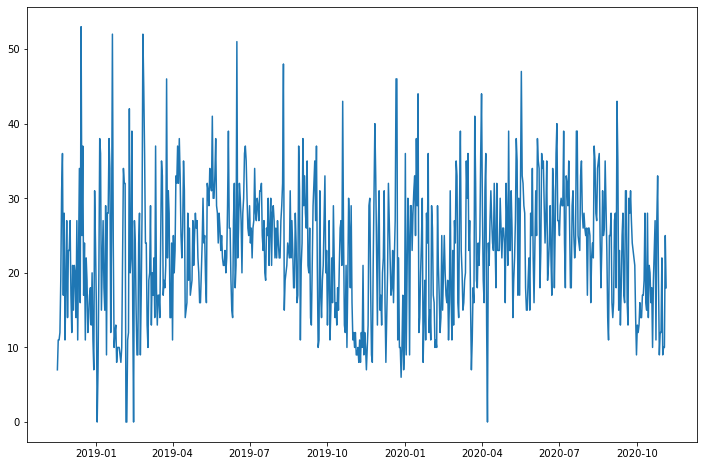

In [23]:
# 让我看看你们都是什么样子
plt.figure(figsize=(12, 8))  # large picture
plt.plot(windspeed.Datetime[sep:],windspeed.iloc[sep:,1])
# 这是风速

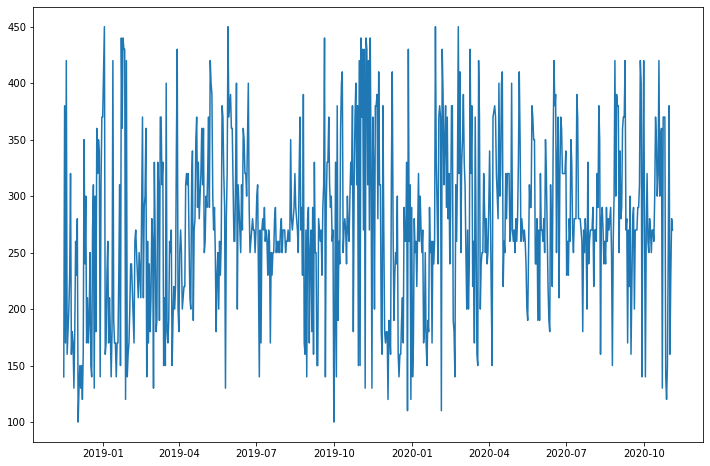

In [24]:
# 魔改风向，希望它的分布能集中一点
winddir1=winddir.copy()
for i in range(len(winddir1)):
    if winddir1.iloc[i,1]<100:
        winddir1.iloc[i,1]+=360
plt.figure(figsize=(12, 8))  # large picture
plt.plot(windspeed.Datetime[sep:],winddir1.iloc[sep:,1])
# 这样应该没什么用

# 用风速和风向来预测风速

In [25]:
# 用风速和风向来预测风速
def get_dataset():
    # data = [maxtempe,mintempe,precip,winddir,windspeed]
    data = [windspeed,winddir1]
    open_arr=[]
    
    # scaler = MinMaxScaler()  #归一化
    scaler=[]  # 一个数据一个scaler

    for i in range(len(data)):
        scaler.append(MinMaxScaler())
        open_arr.append(scaler[i].fit_transform(np.asarray(data[i].iloc[:,1]).reshape(-1, 1)).reshape(-1))
    
    X = np.zeros(shape=(len(open_arr[0])-window_size, len(open_arr)*window_size))  # 长是len-10，宽是[指标数]*10；
    label = np.zeros(shape=(len(open_arr[0])-window_size))  # 长是len-10
    for i in range(len(open_arr[0])-window_size):
        for j in range(len(open_arr)):
            X[i,j*window_size:(j+1)*window_size] = open_arr[j][i:i+window_size]  # X第i行 = 原数据i到i+10（取不到10）的值
        label[i] = open_arr[0][i+window_size]  # label[i] = 原数据i+10的值，X正好取不到
        # 现在预测风速
    
    train_X = X[:sep, :]  # 前面的数据用来训练
    train_label = label[:sep]
    test_X = X[sep-window_size:, :]  # 后面的数据用来测试
    test_label = label[sep-window_size:]
    return train_X, train_label, test_X, test_label, scaler


In [26]:
train_X, train_label, test_X, test_label, scaler = get_dataset()

In [28]:
# 用风速和风向来预测风速
model = keras.models.Sequential([
    keras.layers.Input(shape=(window_size*2, 1)),    # window_size*2的2是open_arr的长
    TCN(nb_filters=filter_nums,     # 滤波器的个数，类比于units
        kernel_size=kernel_size,    # 卷积核的大小
        dilations=[1, 2, 4, 8]),    # 空洞因子
    keras.layers.Dense(units=1, activation='relu')
])
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.fit(train_X, train_label, validation_split=0.2, epochs=epochs)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_4 (TCN)                  (None, 10)                2940      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,951
Trainable params: 2,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
72/72 [==============================] - 2s 22ms/step - loss: 0.2460 - mse: 0.2460 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 2/200
72/72 [==============================] - 1s 15ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 3/200
72/72 [==============================] - 1s 15ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 4/200
72/72 [==============================] - 1s 15ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0177 - va

KeyboardInterrupt: 

In [18]:
model.evaluate(test_X, test_label)

fit = model.predict(train_X)

prediction = model.predict(test_X)
tcn_pre = scaler[0].inverse_transform(prediction.reshape(-1, 1)).reshape(-1)
tcn_fit = scaler[0].inverse_transform(fit.reshape(-1, 1)).reshape(-1)
# 反变换
print('mse of TCN: ', mean_squared_error(tcn_pre,np.asarray(windspeed.iloc[sep:,1])))
# 79.20508013531203

23/23 [==============================] - 0s 6ms/step - loss: 0.0192 - mse: 0.0192
mse of TCN:  602.0527777777778


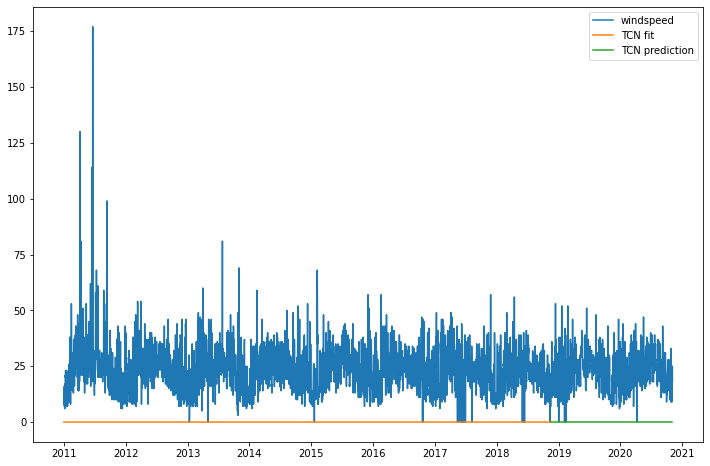

In [15]:
plt.figure(figsize=(12, 8))  # large picture
plt.plot(maxtempe.Datetime,windspeed.iloc[:,1], label='windspeed')
plt.plot(maxtempe.Datetime[:sep], tcn_fit, label='TCN fit')
plt.plot(maxtempe.Datetime[sep:], tcn_pre, label='TCN prediction')
plt.legend()

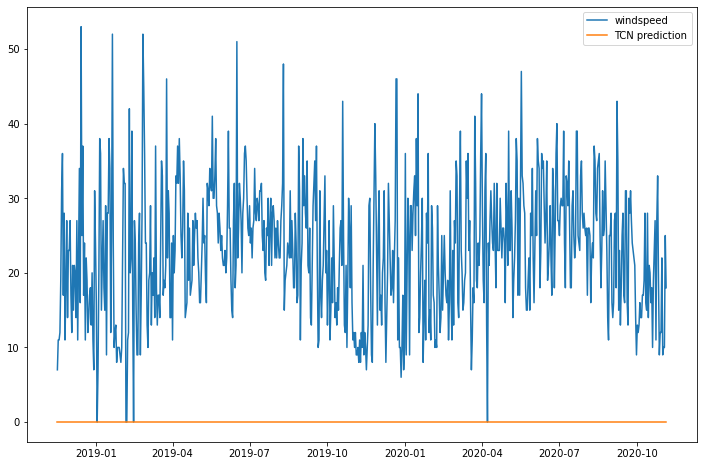

In [16]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))  # large picture
plt.plot(maxtempe.Datetime[sep:],windspeed.iloc[:,1][sep:], label='windspeed')
# plt.plot(maxtempe.Datetime[:sep], tcn_fit, label='TCN fit')
plt.plot(maxtempe.Datetime[sep:], tcn_pre, label='TCN prediction')
plt.legend()

In [17]:
pd.DataFrame(np.concatenate([tcn_fit,tcn_pre])).to_csv('result_TCN_windspeed.csv',index = False)
# 预测的结果，有预测值和拟合值

# 用风速和风向来预测风向

In [43]:
# 用风速和风向来预测风向
def get_dataset2():
    # data = [maxtempe,mintempe,precip,winddir,windspeed]
    data = [windspeed,winddir1]
    open_arr=[]
    
    # scaler = MinMaxScaler()  #归一化
    scaler=[]  # 一个数据一个scaler

    for i in range(len(data)):
        scaler.append(MinMaxScaler())
        open_arr.append(scaler[i].fit_transform(np.asarray(data[i].iloc[:,1]).reshape(-1, 1)).reshape(-1))
    
    X = np.zeros(shape=(len(open_arr[0])-window_size, len(open_arr)*window_size))  # 长是len-10，宽是[指标数]*10；
    label = np.zeros(shape=(len(open_arr[0])-window_size))  # 长是len-10
    for i in range(len(open_arr[0])-window_size):
        for j in range(len(open_arr)):
            X[i,j*window_size:(j+1)*window_size] = open_arr[j][i:i+window_size]  # X第i行 = 原数据i到i+10（取不到10）的值
        label[i] = open_arr[1][i+window_size]  # label[i] = 原数据i+10的值，X正好取不到
        # 现在预测风向
    
    train_X = X[:sep, :]  # 前面的数据用来训练
    train_label = label[:sep]
    test_X = X[sep-window_size:, :]  # 后面的数据用来测试
    test_label = label[sep-window_size:]
    return train_X, train_label, test_X, test_label, scaler


In [44]:
train_X, train_label, test_X, test_label, scaler = get_dataset2()

In [45]:
# 用风速和风向来预测风向
model = keras.models.Sequential([
    keras.layers.Input(shape=(window_size*2, 1)),    # window_size*2的2是open_arr的长
    TCN(nb_filters=filter_nums,     # 滤波器的个数，类比于units
        kernel_size=kernel_size,    # 卷积核的大小
        dilations=[1, 2, 4, 8]),    # 空洞因子
    keras.layers.Dense(units=1, activation='relu')
])
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.fit(train_X, train_label, validation_split=0.2, epochs=epochs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_3 (TCN)                  (None, 10)                2940      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,951
Trainable params: 2,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
72/72 [==============================] - 3s 47ms/step - loss: 0.2435 - mse: 0.2435 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 2/20
72/72 [==============================] - 2s 21ms/step - loss: 0.0698 - mse: 0.0698 - val_loss: 0.0470 - val_mse: 0.0470
Epoch 3/20
72/72 [==============================] - 2s 22ms/step - loss: 0.0551 - mse: 0.0551 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 4/20
72/72 [==============================] - 2s 24ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0444 - val_ms

In [46]:
model.evaluate(test_X, test_label)

fit = model.predict(train_X)

prediction = model.predict(test_X)
tcn_pre = scaler[0].inverse_transform(prediction.reshape(-1, 1)).reshape(-1)
tcn_fit = scaler[0].inverse_transform(fit.reshape(-1, 1)).reshape(-1)
# 反变换

23/23 [==============================] - 0s 7ms/step - loss: 0.0441 - mse: 0.0441


In [49]:
for i in range(len(tcn_pre)):
    if tcn_pre[i]>360:
        tcn_pre[i]-=360
for i in range(len(tcn_fit)):
    if tcn_fit[i]>360:
        tcn_fit[i]-=360
print('mse of TCN: ', mean_squared_error(tcn_pre,np.asarray(winddir.iloc[sep:,1])))
# 35.660855840426294

mse of TCN:  28627.544572321698


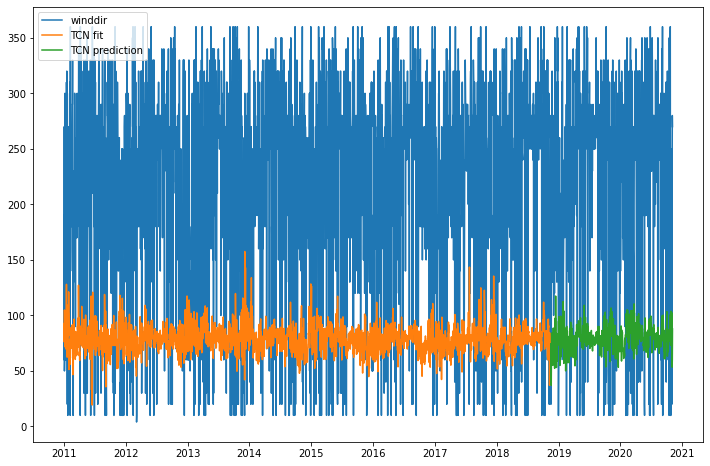

In [50]:
plt.figure(figsize=(12, 8))  # large picture
plt.plot(maxtempe.Datetime,winddir.iloc[:,1], label='winddir')
plt.plot(maxtempe.Datetime[:sep], tcn_fit, label='TCN fit')
plt.plot(maxtempe.Datetime[sep:], tcn_pre, label='TCN prediction')
plt.legend()
# 风向预测有点玄学

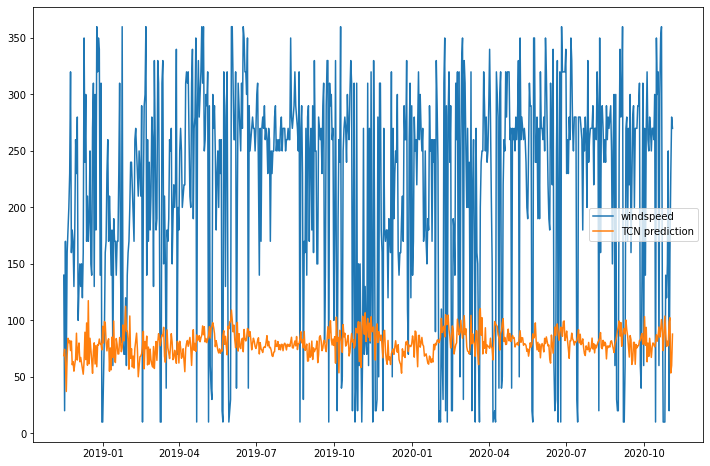

In [51]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))  # large picture
plt.plot(maxtempe.Datetime[sep:],winddir.iloc[:,1][sep:], label='windspeed')
# plt.plot(maxtempe.Datetime[:sep], tcn_fit, label='TCN fit')
plt.plot(maxtempe.Datetime[sep:], tcn_pre, label='TCN prediction')
plt.legend()